In [10]:
from utils import *
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from collections import deque
import random
from sklearn.neighbors import NearestNeighbors

# Configure Modeling Parameters and Fetch Data

Enter a ticker and date range you would like to build the model on.  This model takes a a single ticker's data.  Also enter a training size for the proportion of the data you want to include in your training set vs. your test set.

In [14]:
# stock configs
ticker = ['GOOG']
start_date = '2012-04-01'
end_date = '2024-04-05'

# model configs
train_size = 0.8

In [15]:
# Data Fetching
data = fetch_stock_data(ticker, start_date, end_date)[ticker[0]]
data.reset_index(drop=False, inplace=True)
data['Date'] = pd.to_datetime(data['Date']).dt.tz_localize(None)

print(data.shape)
included_days = len(data)
data.head()

(3021, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2012-04-02,15.959430,16.127052,15.811734,16.112606,91710470,0.0,0.0
1,2012-04-03,16.074997,16.138260,15.906379,16.005507,82102591,0.0,0.0
2,2012-04-04,15.901647,15.915345,15.718583,15.819455,65348026,0.0,0.0
3,2012-04-05,15.746976,15.851335,15.655569,15.748969,93095642,0.0,0.0
4,2012-04-09,15.653327,15.823938,15.573875,15.712107,87635252,0.0,0.0


# Neuro-Evolution Model for Stock Trading with Novelty Search
This neuro-evolution model is an extension of the previous model that incorporates novelty search to optimize a neural network for making stock trading decisions. The model evolves a population of neural networks over multiple generations, using a combination of fitness-based selection and novelty search to find the fittest network that maximizes investment returns while promoting diversity in the population.
## Neural Network Architecture
The neural network architecture remains the same as in the previous model, consisting of an input layer, a hidden layer with ReLU activation, and an output layer with softmax activation. The input layer receives a state vector representing the price differences over a sliding window, and the output layer produces action probabilities for buying, selling, or holding.
## Evolutionary Process
The evolutionary process is similar to the previous model but includes additional steps for novelty search:

Initialization: A population of neural networks is initialized with random weights.
Fitness Evaluation: The fitness of each neural network is evaluated by simulating its trading decisions on historical price data. The fitness is measured as the percentage of investment returns.
Novelty Evaluation: In addition to fitness evaluation, the novelty of each network is assessed based on its similarity to the population and a novelty archive. The novelty score is calculated using the average distance to the k-nearest neighbors in the feature space.
Selection: The population is sorted based on novelty scores, and the top individuals are added to the novelty archive. The winners are selected based on fitness, while the parents for the next generation are selected based on a combination of fitness and novelty scores.
Crossover: Parent networks are paired up, and their weights are crossed over to create child networks. The crossover points are randomly selected for each weight matrix.
Mutation: The child networks undergo mutation, where a small probability of mutation is applied to each weight. The mutation adds random noise to the weights to introduce diversity in the population.
Replacement: The winners, mutated child networks, and individuals from the novelty archive form the population for the next generation.
Iteration: Steps 2-7 are repeated for a specified number of generations or until a satisfactory fitness level is achieved.

## Novelty Search
Novelty search is incorporated into the evolutionary process to promote diversity and explore novel solutions. The novelty of each network is evaluated based on its similarity to the population and a novelty archive. The novelty score is calculated using the average distance to the k-nearest neighbors in the feature space.
The novelty archive is updated regularly with novel individuals from the population. The archive maintains a diverse set of networks that have been found to be novel throughout the evolutionary process.
The selection process considers both fitness and novelty scores to maintain a balance between exploitation (selecting fit individuals) and exploration (selecting novel individuals).
## Trading Simulation
The trading simulation process remains the same as in the previous model. The fittest neural network is used to make buy, sell, or hold decisions based on the current state of the market. The simulation keeps track of the buying and selling states, total gains, and investment percentage.
## Usage
The usage of the neuro-evolution model with novelty search is similar to the previous model:

Prepare the historical price data as a list of closing prices.
Set the initial parameters, such as the initial money, window size, skip size, and novelty search parameters (e.g., novelty threshold, archive size).
Create an instance of the NeuroEvolution class with the desired population size, mutation rate, and other parameters.
Call the evolve method to start the evolutionary process.
Retrieve the fittest neural network after the specified number of generations.
Use the fittest network to simulate trading decisions on new price data.

The incorporation of novelty search in the neuro-evolution model aims to improve the exploration of the search space and discover diverse and potentially valuable trading strategies. By considering both fitness and novelty during the evolutionary process, the model strikes a balance between optimizing for profitability and maintaining diversity in the population.

In [16]:
close = data.Close.values.tolist()
initial_money = 10000
window_size = 30
skip = 1

novelty_search_threshold = 6
novelty_log_maxlen = 1000
backlog_maxsize = 500
novelty_log_add_amount = 3

In [17]:
class NeuralNetwork:
    def __init__(self, id_, hidden_size=128):
        """
        Initialize the neural network.
        
        Args:
            id_ (int): The unique identifier for the network.
            hidden_size (int): The size of the hidden layer (default: 128).
        """
        self.W1 = np.random.randn(window_size, hidden_size) / np.sqrt(window_size)
        self.W2 = np.random.randn(hidden_size, 3) / np.sqrt(hidden_size)
        self.fitness = 0
        self.last_features = None
        self.id = id_

def relu(X):
    """
    Rectified Linear Unit (ReLU) activation function.
    
    Args:
        X (numpy array): Input values.
        
    Returns:
        numpy array: Output values after applying ReLU.
    """
    return np.maximum(X, 0)

def softmax(X):
    """
    Softmax activation function.
    
    Args:
        X (numpy array): Input values.
        
    Returns:
        numpy array: Output values after applying softmax.
    """
    e_x = np.exp(X - np.max(X, axis=-1, keepdims=True))
    return e_x / np.sum(e_x, axis=-1, keepdims=True)

def feed_forward(X, net):
    """
    Feed-forward computation of the neural network.
    
    Args:
        X (numpy array): Input data.
        net (NeuralNetwork): Neural network object.
        
    Returns:
        numpy array: Output probabilities after feed-forward computation.
    """
    a1 = np.dot(X, net.W1)
    z1 = relu(a1)
    a2 = np.dot(z1, net.W2)
    return softmax(a2)


In [26]:

class NeuroEvolution:
    def __init__(self, population_size, mutation_rate, model_generator,
                 state_size, window_size, trend, skip, initial_money):
        """
        Initialize the NeuroEvolution object.
        
        Args:
            population_size (int): The size of the population.
            mutation_rate (float): The probability of mutation.
            model_generator (callable): A function that generates a new neural network model.
            state_size (int): The size of the state vector.
            window_size (int): The size of the sliding window.
            trend (list): The trend data.
            skip (int): The number of steps to skip in the trend data.
            initial_money (float): The initial amount of money.
        """
        self.population_size = population_size
        self.mutation_rate = mutation_rate
        self.model_generator = model_generator
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.initial_money = initial_money
        self.generation_backlog = []
        self.novel_backlog = []
        self.novel_pop = []

    def _initialize_population(self):
        """
        Initialize the population of neural networks.
        """
        self.population = []
        for i in range(self.population_size):
            self.population.append(self.model_generator(i))
    
    def _memorize(self, q, i, limit):
        q.append(i)
        if len(q) > limit:
            q.pop()

    def mutate(self, individual, scale=1.0):
        """
        Mutate the weights of a neural network.
        
        Args:
            individual (NeuralNetwork): The neural network to mutate.
            scale (float): The scale of the mutation (default: 1.0).
            
        Returns:
            NeuralNetwork: The mutated neural network.
        """
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W1.shape)
        individual.W1 += np.random.normal(loc=0, scale=scale, size=individual.W1.shape) * mutation_mask
        mutation_mask = np.random.binomial(1, p=self.mutation_rate, size=individual.W2.shape)
        individual.W2 += np.random.normal(loc=0, scale=scale, size=individual.W2.shape) * mutation_mask
        return individual

    def inherit_weights(self, parent, child):
        """
        Inherit weights from a parent network to a child network.
        
        Args:
            parent (NeuralNetwork): The parent neural network.
            child (NeuralNetwork): The child neural network.
            
        Returns:
            NeuralNetwork: The child neural network with inherited weights.
        """
        child.W1 = parent.W1.copy()
        child.W2 = parent.W2.copy()
        return child

    def crossover(self, parent1, parent2):
        """
        Perform crossover between two parent networks to generate two child networks.
        
        Args:
            parent1 (NeuralNetwork): The first parent neural network.
            parent2 (NeuralNetwork): The second parent neural network.
            
        Returns:
            tuple: Two child neural networks resulting from the crossover.
        """
        child1 = self.model_generator((parent1.id+1)*10)
        child1 = self.inherit_weights(parent1, child1)
        child2 = self.model_generator((parent2.id+1)*10)
        child2 = self.inherit_weights(parent2, child2)
        # first W
        n_neurons = child1.W1.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W1[:, cutoff:] = parent2.W1[:, cutoff:].copy()
        child2.W1[:, cutoff:] = parent1.W1[:, cutoff:].copy()
        # second W
        n_neurons = child1.W2.shape[1]
        cutoff = np.random.randint(0, n_neurons)
        child1.W2[:, cutoff:] = parent2.W2[:, cutoff:].copy()
        child2.W2[:, cutoff:] = parent1.W2[:, cutoff:].copy()
        return child1, child2

    def get_state(self, t):
        """
        Get the state at a given time step.
        
        Args:
            t (int): The time step.
            
        Returns:
            numpy array: The state vector.
        """
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])

    def act(self, p, state):
        """
        Take an action based on the current state.
        
        Args:
            p (NeuralNetwork): The neural network.
            state (numpy array): The current state.
            
        Returns:
            int: The selected action.
        """
        logits = feed_forward(state, p)
        return np.argmax(logits, 1)[0]

    def buy(self, individual):
        """
        Simulate buying and selling based on the decisions of the neural network.
        
        Args:
            individual (NeuralNetwork): The neural network making the decisions.
            
        Returns:
            tuple: The states when buying, states when selling, total gains, and investment percentage.
        """
        initial_money = self.initial_money
        starting_money = initial_money
        state = self.get_state(0)
        inventory = []
        states_sell = []
        states_buy = []
        
        for t in range(0, len(self.trend) - 1, self.skip):
            action = self.act(individual, state)
            next_state = self.get_state(t + 1)
            
            if action == 1 and starting_money >= self.trend[t]:
                inventory.append(self.trend[t])
                initial_money -= self.trend[t]
                states_buy.append(t)
                print('day %d: buy 1 unit at price %f, total balance %f'% (t, self.trend[t], initial_money))
            
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend[t]
                states_sell.append(t)
                try:
                    invest = ((self.trend[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
                print(
                    'day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'
                    % (t, self.trend[t], invest, initial_money)
                )
            state = next_state
        
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        return states_buy, states_sell, total_gains, invest

    def calculate_fitness(self):
        """
        Calculate the fitness of each individual in the population.
        """
        for i in range(self.population_size):
            for i in range(self.population_size):
                initial_money = self.initial_money
                starting_money = initial_money
                state = self.get_state(0)
                inventory = []
                
                for t in range(0, len(self.trend) - 1, self.skip):
                    action = self.act(self.population[i], state)
                    next_state = self.get_state(t + 1)
                
                    if action == 1 and starting_money >= self.trend[t]:
                        inventory.append(self.trend[t])
                        starting_money -= self.trend[t]

                    elif action == 2 and len(inventory):
                        bought_price = inventory.pop(0)
                        starting_money += self.trend[t]

                    state = next_state
                invest = ((starting_money - initial_money) / initial_money) * 100
                self.population[i].fitness = invest
                self.population[i].last_features = self.population[i].W2.flatten()

    def evaluate(self, individual, backlog, pop, k = 4):
        score = 0
        if len(backlog):
            x = np.array(backlog)
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(backlog))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        if len(pop):
            nn = NearestNeighbors(n_neighbors = k, metric = 'euclidean').fit(np.array(pop))
            d, _ = nn.kneighbors([individual])
            score += np.mean(d)
        
        return score

    def evolve(self, generations=20, checkpoint=5):
        """
        Evolve the population of neural networks.
        
        Args:
            generations (int): The number of generations to evolve (default: 20).
            checkpoint (int): The number of generations between each checkpoint (default: 5).
            
        Returns:
            NeuralNetwork: The fittest neural network after evolution.
        """
        self._initialize_population()
        n_winners = int(self.population_size * 0.4)
        n_parents = self.population_size - n_winners
        for epoch in range(generations):
            self.calculate_fitness()
            scores = [self.evaluate(p.last_features, self.novel_backlog, self.novel_pop) for p in self.population]
            sort_fitness = np.argsort(scores)[::-1]
            self.population = [self.population[i] for i in sort_fitness]
            fittest_individual = self.population[0]
            if (epoch+1) % checkpoint == 0:
                print('epoch %d, fittest individual %d with accuracy %f'%(epoch+1, sort_fitness[0], 
                                                                          fittest_individual.fitness))
            next_population = [self.population[i] for i in range(n_winners)]
            total_fitness = np.sum([np.abs(i.fitness) for i in self.population])
            parent_probabilities = [np.abs(i.fitness / total_fitness) for i in self.population]
            parents = np.random.choice(self.population, size=n_parents, p=parent_probabilities, replace=False)
            
            for p in next_population:
                if p.last_features is not None:
                    self._memorize(self.novel_pop, p.last_features, backlog_maxsize)
                    if np.random.randint(0,10) < novelty_search_threshold:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
            for i in np.arange(0, len(parents), 2):
                child1, child2 = self.crossover(parents[i], parents[i+1])
                next_population += [self.mutate(child1), self.mutate(child2)]
            self.population = next_population
            
            if np.random.randint(0,10) < novelty_search_threshold:
                pop_sorted = sorted(self.population, key=lambda p: p.fitness, reverse=True)
                self.generation_backlog.append(pop_sorted[0])
                print('novel add fittest, score: %f, backlog size: %d'%(pop_sorted[0].fitness, 
                                                                        len(self.generation_backlog)))
                generation_backlog_temp = self.generation_backlog
                if len(self.generation_backlog) > backlog_maxsize:
                    generation_backlog_temp = random.sample(self.generation_backlog, backlog_maxsize)
                for p in generation_backlog_temp:
                    if p.last_features is not None:
                        self._memorize(self.novel_backlog, p.last_features, novelty_log_maxlen)
                        
        return fittest_individual


In [28]:
# Example usage
close = data.Close.values.tolist()
initial_money = 10000
window_size = 15
skip = 1

population_size = 50
generations = 10
mutation_rate = 0.1
neural_evolve = NeuroEvolution(population_size, mutation_rate, NeuralNetwork,
                               window_size, window_size, close, skip, initial_money)

fittest_net = neural_evolve.evolve(generations=generations)

novel add fittest, score: 13.028236, backlog size: 1
epoch 5, fittest individual 46 with accuracy -94.347504
novel add fittest, score: 1.560253, backlog size: 2
novel add fittest, score: 1.608292, backlog size: 3
novel add fittest, score: 3.894248, backlog size: 4
novel add fittest, score: 0.781011, backlog size: 5
epoch 10, fittest individual 37 with accuracy -99.248313


In [31]:

states_buy, states_sell, total_gains, invest = neural_evolve.buy(fittest_net)

day 1: buy 1 unit at price 16.005507, total balance 9983.994493
day 8: buy 1 unit at price 15.556690, total balance 9968.437803
day 44: buy 1 unit at price 14.206999, total balance 9954.230804
day 67, sell 1 unit at price 14.595542, investment -8.809247 %, total balance 9968.826346,
day 74: buy 1 unit at price 14.464782, total balance 9954.361565
day 84: buy 1 unit at price 15.757935, total balance 9938.603630
day 93: buy 1 unit at price 16.654076, total balance 9921.949554
day 94: buy 1 unit at price 16.626181, total balance 9905.323374
day 102: buy 1 unit at price 16.668024, total balance 9888.655350
day 105: buy 1 unit at price 16.978361, total balance 9871.676989
day 122: buy 1 unit at price 18.659061, total balance 9853.017927
day 124: buy 1 unit at price 18.841875, total balance 9834.176052
day 127: buy 1 unit at price 18.854080, total balance 9815.321972
day 138: buy 1 unit at price 18.816719, total balance 9796.505253
day 139: buy 1 unit at price 17.310118, total balance 9779.1

In [32]:
import plotly.graph_objects as go

def visualize_stock_trading(close, states_buy, states_sell, total_gains, invest):
    fig = go.Figure()

    # Plot the closing price
    fig.add_trace(go.Scatter(x=list(range(len(close))), y=close, mode='lines', name='Closing Price', line=dict(color='blue', width=2)))

    # Plot the buying signals
    buy_indices = [i for i in range(len(close)) if i in states_buy]
    buy_prices = [close[i] for i in buy_indices]
    fig.add_trace(go.Scatter(x=buy_indices, y=buy_prices, mode='markers', name='Buying Signal', marker=dict(symbol='triangle-up', size=10, color='green')))

    # Plot the selling signals
    sell_indices = [i for i in range(len(close)) if i in states_sell]
    sell_prices = [close[i] for i in sell_indices]
    fig.add_trace(go.Scatter(x=sell_indices, y=sell_prices, mode='markers', name='Selling Signal', marker=dict(symbol='triangle-down', size=10, color='red')))

    # Customize the layout
    fig.update_layout(
        title=f'Total Gains: {total_gains:.2f}, Total Investment: {invest:.2f}%',
        xaxis_title='Day',
        yaxis_title='Price',
        template='plotly_dark',
        hovermode='x',
        legend=dict(x=0, y=1, orientation='h')
    )

    fig.show()

In [33]:
visualize_stock_trading(data.Close, states_buy, states_sell, total_gains, invest)

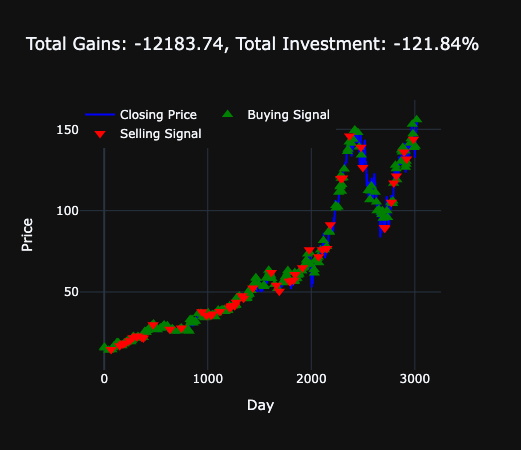